In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
import modutils
import pickle
import time
import sklearn, sklearn.metrics, sklearn.decomposition
import collections
import matplotlib.pyplot as plt

w2v_size = 9000
w2v_file = '../DataSets/Quora/w2v_res_180119.pickle'

In [6]:
%%time
with open(w2v_file, 'rb') as f:
    (full_dict, full_sentences, full_w2v) = pickle.load(f)

Wall time: 1.38 s


In [12]:
def word2idx(word):
    res = [i for (i, (w, _, _, _)) in enumerate(full_dict) if w==word]
    if len(res) == 0:
        return -1
    return res[0]
    
def idx2word(idx):
    if idx >= len(full_dict):
        return '<UNK>'
    return full_dict[idx][0]

def get_elem_occurances(word_id, slist):
    return [(i, j) for (i, x) in enumerate(slist) for (j, y) in enumerate(x) if y==word_id]

def get_elems_with_offset(occurances, sentence_list, offset=0):
    return [sentence_list[i][j+offset] for (i,j) in occurances if j+offset >= 0 and j+offset < len(sentence_list[i])]

def combine_word_counts(wc1, wc2):
    wcf = set.union(set(wc1), set(wc2))
    return dict([(x, (wc1[x] if x in wc1 else 0) + (wc2[x] if x in wc2 else 0)) for x in wcf])

def get_context_distr(word_id, sentence_list, context_window=[(-1, 1), (1, 1)]):
    occurs = get_elem_occurances(word_id, sentence_list)
    wc = dict()
    for (off, prob) in context_window:
        wc_off = get_elems_with_offset(occurs, sentence_list, offset=off)
        wc_tmp = dict(collections.Counter(wc_off))
        wc_tmp = dict([(x, y*prob) for (x, y) in wc_tmp.items()])
        wc = combine_word_counts(wc, wc_tmp)
    return wc

In [21]:
%%time
tmp = [(i, j) for (i, x) in enumerate(full_sentences) for (j, y) in enumerate(x) if y==76]

Wall time: 866 ms


In [34]:
%%time
tmp2 = get_elems_with_offset(tmp, full_sentences, offset=-1)

Wall time: 7.19 ms


In [48]:
%%time
tmp3 = dict(collections.Counter(tmp2))

Wall time: 0 ns


In [71]:
word2idx('king'), word2idx('queen')

(1685, 2716)

In [113]:
%%time
d1 = get_context_distr(word2idx('book'), full_sentences)
d2 = get_context_distr(word2idx('movie'), full_sentences)

Wall time: 1.76 s


In [114]:
sorted([(i, x, idx2word(i)) for (i, x) in d1.items()], key=lambda x: x[1], reverse=True)[:20]

[(19, 993, 'best'),
 (14, 618, 'for'),
 (7, 425, 'to'),
 (0, 422, '?'),
 (6, 380, 'a'),
 (24, 259, 'which'),
 (1, 195, 'the'),
 (3, 179, 'is'),
 (22, 153, 'on'),
 (10, 143, 'of'),
 (45, 132, 'good'),
 (297, 84, 'favorite'),
 (8, 82, 'in'),
 (16, 77, 'you'),
 (2, 68, 'what'),
 (5, 67, 'i'),
 (33, 62, 'should'),
 (27, 61, 'or'),
 (12, 56, 'and'),
 (15, 53, ',')]

In [115]:
sorted([(i, x, idx2word(i)) for (i, x) in d2.items()], key=lambda x: x[1], reverse=True)[:20]

[(1, 685, 'the'),
 (0, 586, '?'),
 (6, 303, 'a'),
 (19, 247, 'best'),
 (10, 219, 'of'),
 (649, 149, 'bollywood'),
 (16, 137, 'you'),
 (8, 132, 'in'),
 (24, 96, 'which'),
 (12, 93, 'and'),
 (363, 90, 'got'),
 (821, 85, 'hollywood'),
 (297, 75, 'favorite'),
 (2, 74, 'what'),
 (15, 73, ','),
 (4721, 64, '2002'),
 (89, 57, 'ever'),
 (3, 50, 'is'),
 (30, 50, 'that'),
 (1760, 45, 'horror')]

In [90]:
idx2word(4295)

'lion'

In [87]:
reduced_size = 1000
reduced_sentences = [[x for x in s if x < reduced_size] for s in full_sentences if min(s) < reduced_size]

In [23]:
def word_dense_vector(sparse_vector, full_size):
    res = np.zeros(full_size)
    for (idx, num) in sparse_vector:
        res[idx] = num
    return res

def word_context_matrix(sentence_list, context_window=[(-1, 1), (1, 1)]):
    words = sorted(list(set([y for x in sentence_list for y in x])))
    rows = []
    for (i,w) in enumerate(words):
        cur_distr = get_context_distr(w, sentence_list, context_window=context_window)
        rows.append(word_dense_vector(cur_distr.items(), len(words)))
        print('{}/{}    '.format(i, len(words)), end='\r')
    return np.array(rows)

In [88]:
tmp = word_context_matrix(reduced_sentences)

In [89]:
tmpf = collections.Counter([z for x in reduced_sentences for z in x])

In [90]:
tmpfreq = word_dense_vector(list(tmpf.items()), reduced_size)

In [91]:
tmpfreq[:10]

array([ 510566.,  225627.,  186557.,  162013.,  132310.,  128457.,
        126457.,  123460.,  117958.,   96484.])

In [222]:
tmp1 = tmp / tmpfreq.reshape(-1,1) / tmpfreq.reshape(1,-1) * np.sum(tmpfreq)

In [223]:
tmp1[tmp1<1]=1
#tmp1[tmp1==0]=1e-10
tmp2 = np.log(tmp1)

In [224]:
tmp2[:10,:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.27309027,  0.        ,  0.40993865,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.10514978,  0.        ,
         0.        ,  0.        ,  0.47894971,  1.2720436 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.41695558,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.60105496],
       [ 0.        ,  2.10514978,  2.41695558,  0.        ,  0.48528924,
         0.        ,  0.89837548,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.48528924,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  2.88148591],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  2.79678164],
       [ 0.27309027,  0.        ,  0.        ,  0.89837548,  0.        ,
         0.        ,  0.        ,  0.68179616

In [231]:
pca = sklearn.decomposition.PCA(200).fit(tmp2)

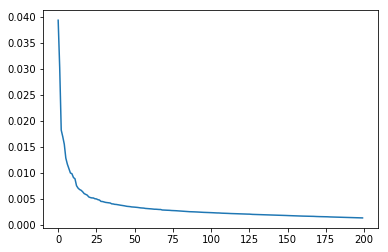

In [232]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

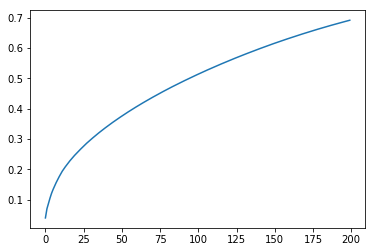

In [233]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [230]:
t0 = np.zeros(shape=(1000,))
t0[100] = 1
pca.transform(t0.reshape(1,-1))

array([[ -7.35813689e+00,  -7.51207542e-01,  -1.31594500e+00,
          9.81655633e-02,  -6.27245732e-02,   3.59939179e-02,
          8.95767449e-01,   2.73527550e+00,  -1.45757113e-01,
          9.38615484e-01,   2.45952802e-01,   1.50664874e+00,
         -7.41128232e-01,   5.98462583e-01,  -2.39676826e-02,
          8.15568379e-01,  -1.42266540e-01,  -2.08840947e-01,
          3.69275735e-01,  -4.17339739e-01,   1.86927376e-01,
         -5.02632467e-01,   3.79530643e-02,   4.95011341e-01,
          9.92961359e-02,   4.95475604e-01,   1.12882629e+00,
         -3.19015660e-01,   2.79724772e-01,  -2.66847117e-01,
          5.12859662e-01,  -1.27241974e-01,  -1.73002092e-01,
         -2.99921329e-02,   2.64257627e-01,   3.37369237e-02,
          2.18022113e-01,  -1.29809069e-01,   1.57208713e-01,
          2.36130238e-02,   3.25370703e-01,  -6.74389664e-02,
          4.07108143e-01,   1.07807031e-01,  -2.99970791e-01,
          3.26863463e-02,   2.75165270e-02,  -8.44994709e-02,
        

In [282]:
def word2vec(word):
    return pca.components_[:,word2idx(word)]

def idx2vec(idx):
    return pca.components_[:,idx]#pca.transform(t0.reshape(1, -1))

In [262]:
ix = word2idx('his')
iy = word2idx('her')
print('{} {}'.format(ix, iy))
x = idx2vec(ix).reshape(-1)[0:]
y = idx2vec(iy).reshape(-1)[0:]
np.dot(x, y) / np.sqrt(np.dot(x, x) * np.dot(y, y))

155 152


0.43080287862203098

In [283]:
pca.components_ - (word2vec('his') - word2vec('he') + word2vec('she'))

ValueError: operands could not be broadcast together with shapes (200,1000) (200,) 

In [297]:
z = (word2vec('president')).reshape(-1,1) - pca.components_

In [298]:
sorted(enumerate(np.diag(np.dot(z.transpose(), z))), key=lambda x: x[1])[:10]

[(178, 0.0),
 (782, 0.13494447178529889),
 (209, 0.1482404832738404),
 (875, 0.15116349056703737),
 (657, 0.151419787936767),
 (883, 0.15240499600292087),
 (867, 0.15242509025213985),
 (78, 0.15332424543857895),
 (429, 0.15663504355643104),
 (835, 0.15763601810628813)]

In [299]:
idx2word(782)

'chances'